<a href="https://colab.research.google.com/github/Derinhelm/parser_stat/blob/natasha_emb/natasha_unk_Russian_parser_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка репозитория

In [1]:
!git clone --branch natasha_emb https://github.com/Derinhelm/parser_stat.git

Cloning into 'parser_stat'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 276 (delta 23), reused 24 (delta 12), pack-reused 231 (from 1)
Receiving objects: 100% (276/276), 49.95 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [2]:
import sys
sys.path.append('/content/parser_stat')

In [3]:
!mkdir pics

# Получение данных

In [4]:
from data_classes import ConllEntry, Sentence

In [5]:
import pickle

In [6]:
with open('/content/parser_stat/treebank_test_sets/treebank_data.pickle', 'rb') as f:
    treebanks = pickle.load(f)

In [7]:
for t, sent_list in treebanks.items():
    print(t, len(sent_list))
    # checking the index uniqueness
    assert len({s.sent_id for s in sent_list}) == len(sent_list)

gsd 601
pud 1000
syntagrus 8800
poetry 728
taiga 881


In [8]:
treebank_names = ['taiga', 'poetry', 'gsd', 'pud', 'syntagrus']

# Получение результатов синтаксического анализа

In [9]:
import pandas as pd

In [10]:
parser_names = ["natasha"]

In [11]:
parser_res = {}
for p in parser_names:
    with open(f'/content/parser_stat/pickle_results/{p}.pickle', 'rb') as f:
       parser_res[p] = pickle.load(f)

In [12]:
for p in parser_names:
  for t in treebanks:
    assert len(treebanks[t]) == len(parser_res[p][t])

In [13]:
for t in treebank_names:
  for p in parser_names:
      print(t, p, len([i for (i, sent) in enumerate(parser_res[p][t])
       if len([t.relation for t in sent.tokens if t.relation == "root"]) > 1]))

taiga natasha 95
poetry natasha 148
gsd natasha 83
pud natasha 98
syntagrus natasha 1073


In [14]:
def shift_token_id(sentence):
  first_token_shift = 0
  for i, t in enumerate(sentence.tokens):
    if t.id == '1':
      first_token_shift = i
    shift_id = str(int(t.id) + first_token_shift)
    if t.parent_id != '0':
      shift_parent_id = str(int(t.parent_id) + first_token_shift)
    else:
      shift_parent_id = '0'
    #print(shift_id, t.id, "    ", shift_parent_id, t.parent_id)
    t.id = shift_id
    t.parent_id = shift_parent_id

In [15]:
for t in treebank_names:
  for p in parser_names:
    for s in parser_res[p][t]:
      shift_token_id(s)

In [16]:
#[(t.id, t.parent_id, t.relation) for t in parser_res['stanza']['syntagrus'][6424].tokens]

# Добавление информации о распознанности эмбеддинга

In [17]:
with open('/content/parser_stat/pickle_results/natasha_emb.pickle', 'rb') as f:
    emb_info = pickle.load(f)

In [18]:
p = 'natasha'
for tr in treebank_names:
  assert len(emb_info[tr]) == len(parser_res[p][tr])
  for s_i, s in enumerate(parser_res[p][tr]):
    assert len(emb_info[tr][s_i]) == len(s.tokens)
    for t_i, t in enumerate(s.tokens):
      t.emb_unk = emb_info[tr][s_i][t_i]

# Создание пар вида (начало токена, конец токена)

be_edges - набор ребер дерева зависимостей в формате (начало токена, конец токена)

In [19]:
from functions import create_sent_be_nodes, create_sent_be_edges

In [20]:
from collections import OrderedDict

In [21]:
be_treebanks = {}
be_token_dict_gold = {}
for treebank_n in treebank_names:
    be_treebanks[treebank_n] = OrderedDict()
    be_token_dict_gold[treebank_n] = OrderedDict()
    for i, sent in enumerate(treebanks[treebank_n]):
        be_sent, be_token_dict_gold[treebank_n][sent.sent_id] = create_sent_be_nodes(sent, lambda text: text.lower())
        be_treebanks[treebank_n][sent.sent_id] = create_sent_be_edges(be_sent)

In [22]:
be_treebanks['syntagrus']['2003Artist_mimansa.xml_130']

{(0, 2): ((16, 20), 'nsubj'),
 (3, 15): ((16, 20), 'advmod'),
 (16, 20): ((-1, -1), 'root'),
 (21, 24): ((25, 34), 'det'),
 (25, 34): ((16, 20), 'obj'),
 (35, 43): ((16, 20), 'advmod'),
 (43, 44): ((16, 20), 'punct')}

In [23]:
be_token_dict_gold['gsd']['test-s600']

{(0, 6): <data_classes.ConllEntry at 0x78df3bc52250>,
 (7, 15): <data_classes.ConllEntry at 0x78df3bc523d0>,
 (16, 19): <data_classes.ConllEntry at 0x78df3bc52550>,
 (20, 29): <data_classes.ConllEntry at 0x78df3bc526d0>,
 (30, 31): <data_classes.ConllEntry at 0x78df3bc52850>,
 (32, 34): <data_classes.ConllEntry at 0x78df3bc529d0>,
 (35, 38): <data_classes.ConllEntry at 0x78df3bc52bd0>,
 (39, 45): <data_classes.ConllEntry at 0x78df3bc52dd0>,
 (46, 48): <data_classes.ConllEntry at 0x78df3bc52f50>,
 (49, 51): <data_classes.ConllEntry at 0x78df3bc53110>,
 (52, 53): <data_classes.ConllEntry at 0x78df3bc53310>,
 (53, 54): <data_classes.ConllEntry at 0x78df3bc53510>}

In [24]:
be_parser_res = {p: {} for p in parser_names}
be_token_dict_parser = {p: {} for p in parser_names}
for p in parser_names:
  if p == 'deeppavlov':
    transform_fun = lambda text: text.lower().replace('``', '"').replace("''", '"')
  else:
    transform_fun = lambda text: text.lower().replace("''", '"')
  for t in treebank_names:
    be_parser_res[p][t] = OrderedDict()
    be_token_dict_parser[p][t] = OrderedDict()
    for i, sent in enumerate(parser_res[p][t]):
        be_sent, be_token_dict_parser[p][t][sent.sent_id] = create_sent_be_nodes(sent, transform_fun)
        be_parser_res[p][t][sent.sent_id] = create_sent_be_edges(be_sent)

In [25]:
be_parser_res['natasha']['gsd']['test-s1']

{(0, 5): ((6, 11), 'nsubj'),
 (6, 11): ((-1, -1), 'root'),
 (12, 18): ((6, 11), 'xcomp'),
 (19, 21): ((32, 38), 'case'),
 (22, 31): ((32, 38), 'amod'),
 (32, 38): ((101, 110), 'obl'),
 (39, 40): ((41, 46), 'punct'),
 (40, 41): ((46, 47), 'punct'),
 (41, 46): ((32, 38), 'appos'),
 (46, 47): ((46, 47), 'flat:foreign'),
 (47, 48): ((46, 47), 'punct'),
 (48, 50): ((46, 47), 'appos'),
 (50, 51): ((41, 46), 'punct'),
 (51, 52): ((46, 47), 'conj'),
 (52, 53): ((51, 52), 'punct'),
 (53, 55): ((52, 53), 'appos'),
 (55, 56): ((101, 110), 'punct'),
 (57, 58): ((59, 67), 'case'),
 (59, 67): ((101, 110), 'obl'),
 (68, 70): ((71, 74), 'nummod'),
 (71, 74): ((59, 67), 'nmod'),
 (74, 75): ((101, 110), 'punct'),
 (76, 77): ((101, 110), 'cc'),
 (78, 83): ((84, 88), 'case'),
 (84, 88): ((101, 110), 'obl'),
 (89, 96): ((84, 88), 'nmod'),
 (97, 100): ((101, 110), 'aux:pass'),
 (101, 110): ((-1, -1), 'root'),
 (111, 112): ((122, 128), 'case'),
 (113, 121): ((122, 128), 'amod'),
 (122, 128): ((101, 110), 'ob

In [26]:
be_token_dict_parser['natasha']['gsd']['test-s1']

{(0, 5): <data_classes.ConllEntry at 0x78df39a6a510>,
 (6, 11): <data_classes.ConllEntry at 0x78df582b3950>,
 (12, 18): <data_classes.ConllEntry at 0x78df39a6bf10>,
 (19, 21): <data_classes.ConllEntry at 0x78df39a70350>,
 (22, 31): <data_classes.ConllEntry at 0x78df39a70b10>,
 (32, 38): <data_classes.ConllEntry at 0x78df39a71350>,
 (39, 40): <data_classes.ConllEntry at 0x78df39a71ad0>,
 (40, 41): <data_classes.ConllEntry at 0x78df39a72110>,
 (41, 46): <data_classes.ConllEntry at 0x78df39a72750>,
 (46, 47): <data_classes.ConllEntry at 0x78df39a72dd0>,
 (47, 48): <data_classes.ConllEntry at 0x78df39a73810>,
 (48, 50): <data_classes.ConllEntry at 0x78df39a73e90>,
 (50, 51): <data_classes.ConllEntry at 0x78df39a78850>,
 (51, 52): <data_classes.ConllEntry at 0x78df39a78f90>,
 (52, 53): <data_classes.ConllEntry at 0x78df39a797d0>,
 (53, 55): <data_classes.ConllEntry at 0x78df39a7a050>,
 (55, 56): <data_classes.ConllEntry at 0x78df39a7ac90>,
 (57, 58): <data_classes.ConllEntry at 0x78df39a7b6

# Создание графов для деревьев зависимостей

In [28]:
import networkx as nx

def create_graph(s):
  tokens = [t for t in s.tokens if '.' not in t.id]
  s.graph = nx.DiGraph()
  s.graph.add_node('0', word='root')
  for w in tokens:
    s.graph.add_node(w.id, word=w.form)
  for w in tokens:
    s.graph.add_edge(w.parent_id, w.id, dep_rel=w.relation)

  for t in tokens:
      t.root_depth = nx.shortest_path_length(s.graph, '0', t.id)
  s.graph_depth = max(t.root_depth for t in tokens)

for treebank_n in treebank_names:
    for sent_i in range(len(treebanks[treebank_n])):
      create_graph(treebanks[treebank_n][sent_i])

# Статистика на уровне предложений

In [29]:
def calculate_stat(be_gold, be_res_p):
  stat_list = []
  for sent_id in be_gold:
    extra_gold = len(be_gold[sent_id].keys() - be_res_p[sent_id].keys())
    extra_parser = len(be_res_p[sent_id].keys() - be_gold[sent_id].keys())
    tokenisation_matched = len({t_be for t_be in be_res_p[sent_id].keys() & be_gold[sent_id].keys()})
    parent_matched = len({t_be for t_be in be_res_p[sent_id].keys() & be_gold[sent_id].keys()
      if be_res_p[sent_id][t_be][0] == be_gold[sent_id][t_be][0]})
    relation_matched = len({t_be for t_be in be_res_p[sent_id].keys() & be_gold[sent_id].keys()
      if be_res_p[sent_id][t_be] == be_gold[sent_id][t_be]})
    stat_list.append((sent_id, extra_gold, extra_parser, tokenisation_matched,
                      parent_matched, relation_matched, len(be_gold[sent_id])))
  stat = pd.DataFrame(stat_list, columns=['sent_id', 'extra_gold', 'extra_parser', 'tokenisation_matched',
                                             'parent_matched', 'relation_matched', 'token_length'])

  align_uas_precision = stat['parent_matched'] / (stat['extra_parser'] + stat['tokenisation_matched'])
  align_uas_recall = stat['parent_matched'] / (stat['extra_gold'] + stat['tokenisation_matched'])
  align_las_precision = stat['relation_matched'] / (stat['extra_parser'] + stat['tokenisation_matched'])
  align_las_recall = stat['relation_matched'] / (stat['extra_gold'] + stat['tokenisation_matched'])
  align_uas_f = ((2 * align_uas_precision * align_uas_recall) / (align_uas_precision + align_uas_recall)).fillna(0.0)
  align_las_f = ((2 * align_las_precision * align_las_recall) / (align_las_precision + align_las_recall)).fillna(0.0)
  return align_uas_f, align_las_f

In [30]:
align_uas_f = {treebank: {} for treebank in treebank_names}
align_las_f = {treebank: {} for treebank in treebank_names}
for treebank in treebank_names:
  for p in parser_names:
    align_uas_f[treebank][p], align_las_f[treebank][p] = \
        calculate_stat(be_treebanks[treebank], be_parser_res[p][treebank])
align_res = {"uas_f": align_uas_f,
             "las_f": align_las_f}

In [31]:
parser_titles = ["Natasha"]
treebank_titles = ["Taiga", "Poetry", "GSD", "PUD", "SynTagRus"]

In [32]:
import numpy as np

def get_ax(ax, lang_i, x_count, y_count):
    if isinstance(ax[0], np.ndarray):
      x = lang_i // y_count
      y = lang_i % y_count
      return ax[x, y]
    else:
      return ax[lang_i]

# Сравнение на уровне токенов

## Создание статистики на уровне токенов

In [33]:
[len(be_treebanks[tr]) for tr in treebank_names]

[881, 728, 601, 1000, 8800]

In [34]:
[[len(be_parser_res[p][tr]) for tr in treebank_names] for p in parser_names]

[[881, 728, 601, 1000, 8800]]

In [35]:
import pandas as pd
import numpy as np

In [37]:
result_df = {}
for tr in treebank_names:
    data_to_df = []
    for sent_i, sent_be in be_treebanks[tr].items():
        for gold_token_be, (gold_parent_be, gold_type) in sent_be.items():
          token_dict = { 'sent_i': sent_i, 'gold_token': gold_token_be,
                        'gold_parent': gold_parent_be, 'gold_type': gold_type}
          gold_token = be_token_dict_gold[tr][sent_i][gold_token_be]
          token_dict['gold_pos'] = gold_token.pos
          token_dict['gold_relation'] = gold_token.relation
          token_dict['gold_depth'] = gold_token.root_depth
          if gold_parent_be != (-1, -1):
              gold_parent = be_token_dict_gold[tr][sent_i][gold_parent_be]
              dep_len = int(gold_token.id) - int(gold_parent.id)
          else:
              dep_len = np.nan
          token_dict['gold_dep_len'] = dep_len
          for p in parser_names:
            if gold_token_be in be_parser_res[p][tr][sent_i]:
              token_dict[f'{p}_parent'], token_dict[f'{p}_type'] = be_parser_res[p][tr][sent_i][gold_token_be]
              parser_token = be_token_dict_parser[p][tr][sent_i][gold_token_be]
              token_dict[f'{p}_emb_unk'] = parser_token.emb_unk
            else:
              token_dict[f'{p}_parent'], token_dict[f'{p}_type'] = None, None
              token_dict[f'{p}_emb_unk'] = None

          data_to_df.append( token_dict)

    result_df[tr] = pd.DataFrame(data_to_df)

In [38]:
result_df['taiga'].head(20)

,sent_i,gold_token,gold_parent,gold_type,gold_pos,gold_relation,gold_depth,gold_dep_len,natasha_parent,natasha_type,natasha_emb_unk
0,1,"(0, 3)","(4, 9)",advmod,ADV,advmod,3,-1.0,"(4, 9)",advmod,False
1,1,"(4, 9)","(12, 18)",obl,NOUN,obl,2,-2.0,"(29, 33)",obl,False
2,1,"(10, 11)","(12, 18)",case,ADP,case,2,-1.0,"(12, 18)",case,False
3,1,"(12, 18)","(-1, -1)",root,NOUN,root,1,NaN,"(29, 33)",obl,False
4,1,"(19, 22)","(12, 18)",nmod,PROPN,nmod,2,1.0,"(12, 18)",nmod,False
5,1,"(23, 24)","(25, 28)",cc,CCONJ,cc,4,-1.0,"(25, 28)",cc,False
6,1,"(25, 28)","(19, 22)",conj,PROPN,conj,3,2.0,"(19, 22)",conj,False
7,1,"(29, 33)","(12, 18)",cop,AUX,cop,2,4.0,"(-1, -1)",root,False
8,1,"(34, 39)","(40, 43)",advmod,ADV,advmod,4,-1.0,"(29, 33)",nsubj,False
9,1,"(40, 43)","(44, 50)",nummod:gov,NUM,nummod:gov,3,-1.0,"(44, 50)",nummod,True


In [39]:
def f_parent(d):
  #print(d, "\n\n")
  right_amount = len(d[d['gold_parent'] == d['parser_parent']])
  return (right_amount, right_amount / len(d), len(d))

def f_parent_relation(d):
  right_amount = len(d[(d['gold_parent'] == d['parser_parent']) & (d['gold_relation'] == d['parser_relation'])])
  return (right_amount, right_amount / len(d), len(d))

def create_property_stat(df, p, prop, labeled=False):
    if labeled:
      f = f_parent_relation
    else:
      f = f_parent
    d = df.rename(columns={ f'{p}_parent': 'parser_parent',
                            f'{p}_type': 'parser_relation'}).groupby(prop)[['gold_parent', 'parser_parent',
                            'gold_relation', 'parser_relation']].apply(f).to_frame('group_stat')
    d['right'] = d['group_stat'].apply(lambda x: x[0])
    d['right_percent'] = d['group_stat'].apply(lambda x: x[1])
    d['all'] = d['group_stat'].apply(lambda x: x[2])
    d.drop('group_stat', axis=1, inplace=True)
    return d

In [40]:
for tr in treebank_names:
  print(tr, len(result_df[tr]))

taiga 10274
poetry 10038
gsd 11385
pud 19355
syntagrus 157718


# Доля токенов с верным/неверным unk (вычисление по всем токенам)

In [59]:
unk_stat = {}
for tr in treebank_names:
  unk_stat[tr] = pd.DataFrame({'uas': align_uas_f[tr]['natasha'], 'las': align_las_f[tr]['natasha']})
  unk_stat[tr][f'uas_bins'] = pd.cut(unk_stat[tr]['uas'], include_lowest=True, right=False,
                           bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.1])
  unk_stat[tr][f'las_bins'] = pd.cut(unk_stat[tr]['las'], include_lowest=True, right=False,
                           bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.1])
  unk_stat[tr]['unk_amount'] = [ len([t for t in s.tokens if t.emb_unk]) for s in parser_res['natasha'][tr] ]
  unk_stat[tr]['sent_len'] = [ len(s.tokens) for s in parser_res['natasha'][tr] ]
  unk_stat[tr]['unk_proportion'] = unk_stat[tr]['unk_amount'] / unk_stat[tr]['sent_len']
  unk_stat[tr]['unk_amount_bins'] = pd.cut(unk_stat[tr]['unk_amount'], include_lowest=True, right=False,
                           bins=[0, 10, 20, 30, 40, 50, 1000])
  unk_stat[tr]['unk_proportion_bins'] = pd.cut(unk_stat[tr]['unk_proportion'], include_lowest=True, right=False,
                           bins=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.1])
  unk_stat[tr]['sent_len_bins'] = pd.cut(unk_stat[tr]['sent_len'], include_lowest=True, right=False,
                           bins=[0, 10, 20, 30, 40, 50, 60, 70, 1000])

In [60]:
unk_stat[tr]

,uas,las,uas_bins,las_bins,unk_amount,sent_len,unk_proportion,unk_amount_bins,unk_proportion_bins,sent_len_bins
0,0.827586,0.689655,"[0.8, 1.0)","[0.6, 0.8)",2,14,0.142857,"[0, 10)","[0.0, 0.2)","[10, 20)"
1,0.941176,0.882353,"[0.8, 1.0)","[0.8, 1.0)",1,17,0.058824,"[0, 10)","[0.0, 0.2)","[10, 20)"
2,0.935484,0.903226,"[0.8, 1.0)","[0.8, 1.0)",4,31,0.129032,"[0, 10)","[0.0, 0.2)","[30, 40)"
3,0.900000,0.866667,"[0.8, 1.0)","[0.8, 1.0)",5,30,0.166667,"[0, 10)","[0.0, 0.2)","[30, 40)"
4,1.000000,1.000000,"[1.0, 1.1)","[1.0, 1.1)",1,7,0.142857,"[0, 10)","[0.0, 0.2)","[0, 10)"
...,...,...,...,...,...,...,...,...,...,...
8795,0.857143,0.857143,"[0.8, 1.0)","[0.8, 1.0)",5,7,0.714286,"[0, 10)","[0.6, 0.8)","[0, 10)"
8796,1.000000,1.000000,"[1.0, 1.1)","[1.0, 1.1)",3,3,1.000000,"[0, 10)","[1.0, 1.1)","[0, 10)"
8797,0.800000,0.600000,"[0.8, 1.0)","[0.6, 0.8)",4,10,0.400000,"[0, 10)","[0.4, 0.6)","[10, 20)"
8798,0.866667,0.733333,"[0.8, 1.0)","[0.6, 0.8)",3,15,0.200000,"[0, 10)","[0.2, 0.4)","[10, 20)"


In [61]:
import matplotlib.pyplot as plt


In [62]:
column_names = sorted(list(unk_stat['syntagrus']['unk_proportion_bins'].unique()))
row_names = sorted(list(unk_stat['syntagrus']['uas_bins'].unique()))

In [63]:
import seaborn as sns

In [64]:
treebank_names_sorted = sorted(treebank_names, key=lambda tr: -len(align_uas_f[tr]['natasha']))
treebank_names_sorted

['syntagrus', 'pud', 'taiga', 'poetry', 'gsd']

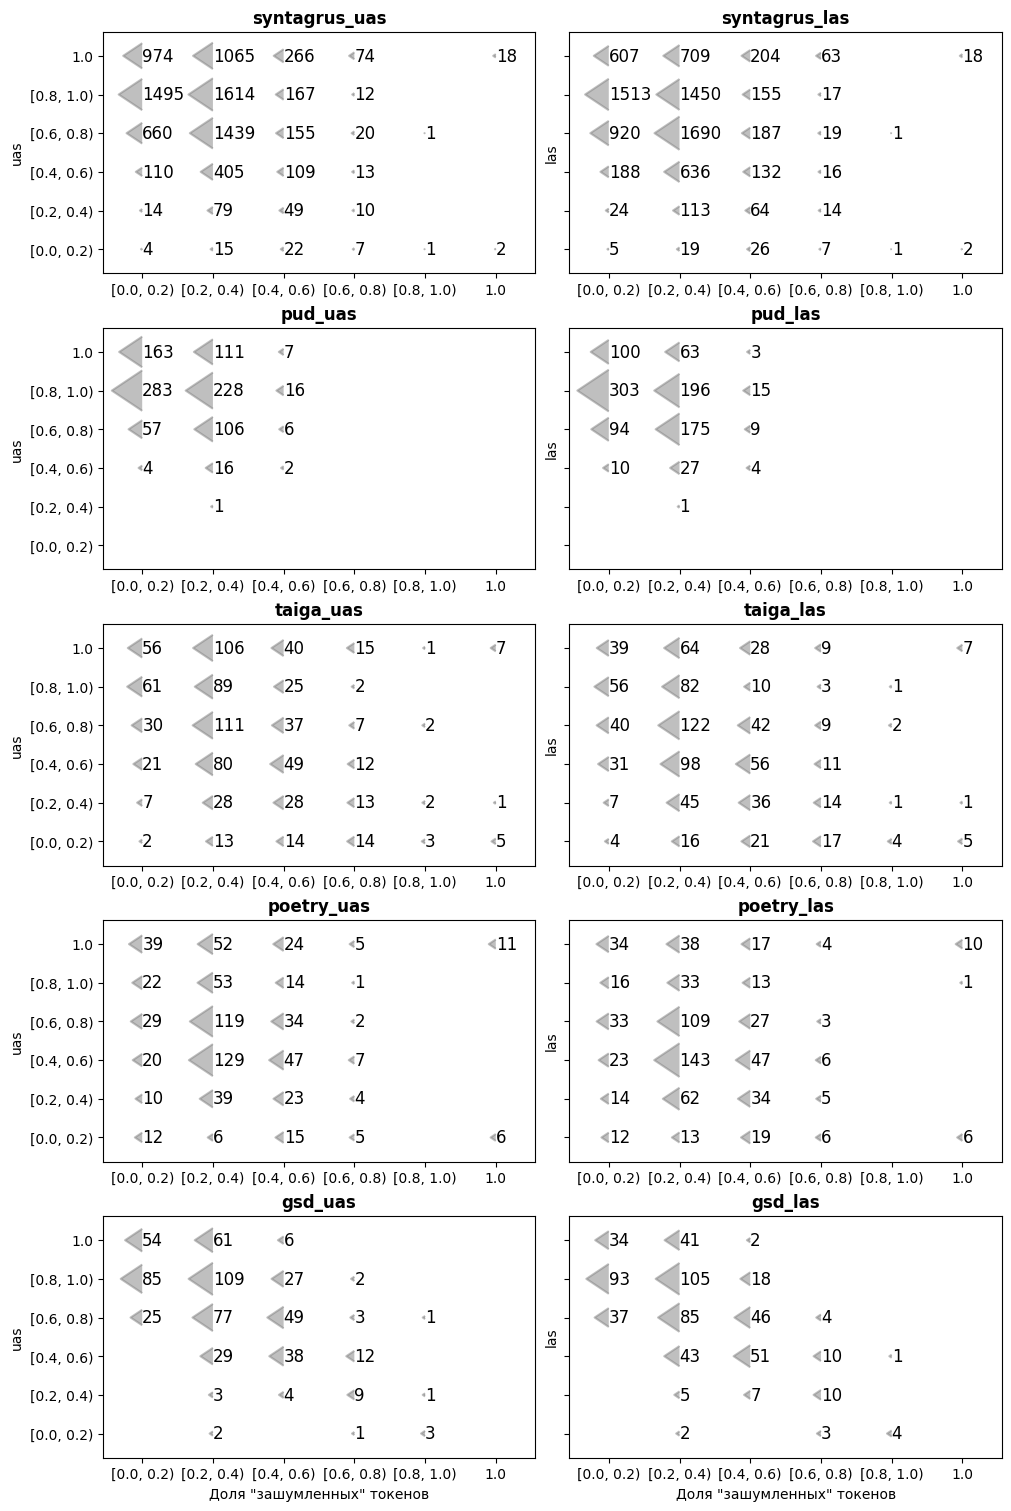

In [66]:
f, axs = plt.subplots(len(treebank_names_sorted), 2, figsize=(10, 15), constrained_layout=True, sharey=True)
#f.autofmt_xdate(rotation=75)

x_dict = {'[0.0, 0.2)': 0.0,
          '[0.2, 0.4)': 0.9,
          '[0.4, 0.6)': 1.8,
          '[0.6, 0.8)': 2.7,
          '[0.8, 1.0)': 3.6,
          '[1.0, 1.1)': 4.5}

y_dict = {'[0.0, 0.2)': 0.0,
          '[0.2, 0.4)': 0.8,
          '[0.4, 0.6)': 1.6,
          '[0.6, 0.8)': 2.4,
          '[0.8, 1.0)': 3.2,
          '[1.0, 1.1)': 4.0}

x_step = 0.9
y_step = 0.8

for ax_r, tr in enumerate(treebank_names_sorted):
  for ax_c, metric in enumerate(['uas', 'las']):
    vc_stat_norm = unk_stat[tr][['unk_proportion_bins', f'{metric}_bins']].value_counts(normalize=True).sort_index()
    vc_stat = unk_stat[tr][['unk_proportion_bins', f'{metric}_bins']].value_counts().sort_index()
    x = []
    y = []
    s = []
    labs = []
    for pr, m in vc_stat.index:
        #if pr.left == 1.0:
        #  x.append('1.0')
        #else:
        x.append(str(pr))
        #if m.left == 1.0:
        #  y.append('1.0')
        #else:
        y.append(str(m))
        s.append(vc_stat_norm[pr][m])
        labs.append(vc_stat[pr][m])

    axs[ax_r][ax_c].scatter([x_dict[x_lab] for x_lab in x], [y_dict[y_lab] for y_lab in y], [s_val * 3000 for s_val in s], alpha=0.5, color='grey', marker=8)
    for i in range(len(x)):
        axs[ax_r][ax_c].text(x_dict[x[i]], y_dict[y[i]], labs[i], ha='left', va='center', size=12)
    if ax_r == len(treebank_names_sorted) - 1:
      axs[ax_r][ax_c].set_xlabel('Доля "зашумленных" токенов')
    axs[ax_r][ax_c].set_xticks(ticks=list(x_dict.values()), labels=list(x_dict.keys())[:-1] + ['1.0'], fontsize=10)
    axs[ax_r][ax_c].set_yticks(ticks=list(y_dict.values()), labels=list(y_dict.keys())[:-1] + ['1.0'], fontsize=10)
    axs[ax_r][ax_c].set_xlim(-0.5, 5.0)
    axs[ax_r][ax_c].set_ylim(-0.5, 4.5)
    axs[ax_r][ax_c].set_ylabel(metric)
    axs[ax_r][ax_c].set_title(f'{tr}_{metric}', weight='bold')
plt.savefig('relative_proportion_metric.pdf', bbox_inches='tight')
plt.show()

# Анализ зашумленных предложений с высокими значениями метрик

In [68]:
sent_id_i_dict = {tr: {} for tr in treebank_names}
for tr in treebank_names:
  for i, s in enumerate(treebanks[tr]):
    sent_id_i_dict[tr][s.sent_id] = i

In [71]:
from collections import Counter

def f(r):
  return sorted(list(Counter([(float(r_v[0]), float(r_v[1])) for r_v in r.values]).items()))

sent_len8_df = {}
for tr in treebank_names:
  stat_list = []
  a = unk_stat[tr][unk_stat[tr]['unk_proportion'] >= 0.8].round(2).groupby('sent_len')[['unk_proportion', 'uas']].apply(f).to_dict()
  for sent_len_key in a.keys():
    for (unk_p, uas_m), amount in a[sent_len_key]:
      stat_list.append((sent_len_key, unk_p, uas_m, amount))
  sent_len8_df[tr] = pd.DataFrame(stat_list, columns=['sent_len', 'unk_proportion', 'uas', 'amount']).sort_values(by=['sent_len', 'unk_proportion', 'uas'])

In [103]:
for tr in treebank_names_sorted:
  print(tr)
  print(sent_len8_df[tr].round(2))
  print()

syntagrus
   sent_len  unk_proportion   uas  amount
0         2             1.0  0.00       1
1         2             1.0  1.00      14
2         3             1.0  0.00       1
3         3             1.0  1.00       4
4         5             0.8  0.14       1
5         5             0.8  0.60       1

pud
Empty DataFrame
Columns: [sent_len, unk_proportion, uas, amount]
Index: []

taiga
    sent_len  unk_proportion   uas  amount
0          1            1.00  0.00       2
1          2            1.00  0.00       2
2          2            1.00  1.00       7
3          3            1.00  0.00       1
4          5            0.80  0.20       1
5          5            0.80  0.60       1
6          5            0.80  1.00       1
7          6            0.83  0.00       1
8          6            0.83  0.18       1
9          7            1.00  0.31       1
10        10            0.80  0.24       1
11        10            0.90  0.70       1
12        15            0.87  0.08       1

poetry

In [75]:
unk_stat['taiga'][(unk_stat['taiga']['sent_len'] > 7) & (unk_stat['taiga']['uas'] >= 0.7) & (unk_stat['taiga']['unk_proportion'] >= 0.8)]

,uas,las,uas_bins,las_bins,unk_amount,sent_len,unk_proportion,unk_amount_bins,unk_proportion_bins,sent_len_bins
680,0.7,0.7,"[0.6, 0.8)","[0.6, 0.8)",9,10,0.9,"[0, 10)","[0.8, 1.0)","[10, 20)"


In [76]:
len(treebanks['taiga'][680].tokens), treebanks['taiga'][680].text

(10, 'Поцелуйте, обнимите, догоните, встретьтесь, скажите.')

In [77]:
align_uas_f['taiga']['natasha'][680]

np.float64(0.7)

In [79]:
unk_stat['gsd'][(unk_stat['gsd']['sent_len'] > 7) & (unk_stat['gsd']['uas'] >= 0.7) & (unk_stat['gsd']['unk_proportion'] >= 0.8)]

,uas,las,uas_bins,las_bins,unk_amount,sent_len,unk_proportion,unk_amount_bins,unk_proportion_bins,sent_len_bins
115,0.75,0.583333,"[0.6, 0.8)","[0.4, 0.6)",10,12,0.833333,"[10, 20)","[0.8, 1.0)","[10, 20)"


In [80]:
align_uas_f['gsd']['natasha'][115]

np.float64(0.75)

In [81]:
len(treebanks['gsd'][115].tokens), treebanks['gsd'][115].text

(12, 'Алекса́ндр Илларио́нович Козло́в (1816 -- 1893) -- русский врач.')

In [106]:
tr = 'taiga'
sent_len8_df[tr][sent_len8_df[tr]['sent_len'] > 6]

,sent_len,unk_proportion,uas,amount
9,7,1.00,0.31,1
10,10,0.80,0.24,1
11,10,0.90,0.70,1
12,15,0.87,0.08,1


In [107]:
tr = 'gsd'
sent_len8_df[tr][sent_len8_df[tr]['sent_len'] > 6]

,sent_len,unk_proportion,uas,amount
1,12,0.83,0.75,1
2,54,0.87,0.18,1
3,59,0.95,0.05,1
4,305,0.83,0.17,1
